In [ ]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
    #tensor = 128 (images) x 784 (=28x28)
    data = tensor.detach().cpu().view(-1, ch, *size) # 128 x 1 x 28 x 28
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # change the order of dimensions: 1 x 28 x 28 = 28 x 28 x 1
    plt.imshow(grid)
    plt.show()

In [ ]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

# hyperparameters
z_dim = 64 # size of the random noise vector
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128 # batch_size
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps = 60000 (images) / 128 (batch size) = 468.75 --> 469

100%|██████████| 9912422/9912422 [00:00<00:00, 112774604.50it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 101794700.69it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 186151254.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19012503.76it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
from torch.nn.modules.activation import Sigmoid
# declare our models

# Generator
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 x 128
            genBlock(h_dim, h_dim*2), # 128 x 256
            genBlock(h_dim*2, h_dim*4), # 256 x 512
            genBlock(h_dim*4, h_dim*8), # 512 x 1024
            nn.Linear(h_dim*8, i_dim), # 1024 x 784 (28x28)
            nn.Sigmoid(), # sets values between 0 and 1
        )

    def forward(self, noise):
        return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device) # to store on GPU

# Discriminator
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784 x 1024
            discBlock(h_dim*4, h_dim*2), # 1024 x 512
            discBlock(h_dim*2, h_dim), #512 x 256
            nn.Linear(h_dim, 1) # 256 x 1
        )

    def forward(self, image):
        return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([0, 0, 4, 6, 9, 3, 0, 4, 0, 2])


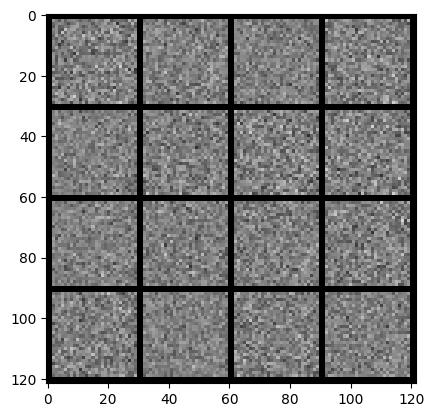

In [ ]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)

    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)

    return gen_loss

# discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)

    disc_fake = disc(fake.detach())
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss)/2

    return disc_loss

In [ ]:
# 60000 / 128 = 468.75 = 469 steps in each epoch
# Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
    cur_step = 0
    for real, _ in tqdm(dataloader): # we use _ since we do not need labels in GAN
        # discriminator
        disc_opt.zero_grad()

        cur_bs = len(real) # real (except last time) = 128 x 1 x 28 x 28
        real = real.view(cur_bs, -1) # 128 x 784
        real = real.to(device) # store images on the GPU

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # visualization & stats
        mean_disc_loss += disc_loss.item()/info_step # item() translates tensor value to an individual value
        mean_gen_loss += gen_loss.item()/info_step

        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)
            print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")
            mean_gen_loss, mean_disc_loss = 0, 0

        cur_step += 1
